# 1. Parameters

In [1]:
from pathlib import Path
from os import mkdir
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cases_root_dir = Path('cases')

figures_path = Path('figures')
if not figures_path.exists():
    mkdir(figures_path)
    
samples_cases = [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
cases_paths = [cases_root_dir / f'case-{x}' for x in samples_cases]

metadata_file = Path('input/metadata-subsample-pangolin.tsv')

# 2. Indexing

## 2.1. Samples comparison

In [2]:
from typing import List

index_info_paths = [x / 'index-info.tsv' for x in cases_paths]
index_info_paths = [x for x in index_info_paths if x.exists()]

def read_all_df(index_paths: List[Path]) -> pd.DataFrame:
    dfs = []
    for index in index_paths:
        dfs.append(pd.read_csv(index, sep='\t'))
        
    return pd.concat(dfs).reset_index(drop=True)

index_info_df = read_all_df(index_info_paths)
index_info_df['Samples'] = index_info_df['Name'].str.extract(r'^case-(\d+)').astype(int)
index_info_df['Number features (unknown)'] = index_info_df['Number features (all)'] - \
                                             index_info_df['Number features (no unknown)']
index_info_df[
    'Percent of reference genome with unknown/missing features'] = 100 * (index_info_df[
    'Number features (unknown)'] / index_info_df['Reference length'])
index_info_df.head(5)

,Name,Iteration,Number samples,Number features (all),Number features (no unknown),Number cores,Reference length,Analysis runtime,Analysis memory (max),Analysis memory (max/process),...,Index memory (max/process),Index size,Tree runtime,Tree memory (max),Tree memory (max/process),Total runtime,Max memory,Samples,Number features (unknown),Percent of reference genome with unknown/missing features
0,case-10,1,10,2900,44,32,29903,139.78,1.429692e+09,377692160.0,...,234856448.0,761856.0,92.58,249139200.0,219570176.0,237.23,5.391446e+09,10,2856,9.550881
1,case-10,2,10,2900,44,32,29903,138.50,1.448071e+09,368533504.0,...,235270144.0,757760.0,82.70,249458688.0,220327936.0,225.89,5.393736e+09,10,2856,9.550881
2,case-10,3,10,2900,44,32,29903,139.58,1.444766e+09,380194816.0,...,234606592.0,761856.0,82.05,248881152.0,219791360.0,226.14,5.389349e+09,10,2856,9.550881
3,case-20,1,20,11560,61,32,29903,137.43,1.815732e+09,366129152.0,...,271831040.0,1957888.0,114.02,241582080.0,220491776.0,258.05,5.498565e+09,20,11499,38.454336
4,case-20,2,20,11560,61,32,29903,156.56,1.670365e+09,371167232.0,...,267173888.0,1961984.0,118.27,240123904.0,220340224.0,281.66,5.496709e+09,20,11499,38.454336


### 2.1.1. Common styles 

In [3]:
stages_palette = ['#1b9e77', '#7570b3', '#d95f02', '#000000']
stages_markers = ['o', 's', '^', 'X']
stages_palette_nototal = ['#1b9e77', '#7570b3', '#d95f02']
stages_markers_nototal = ['o', 's', '^']
stages_palette_notree = ['#1b9e77', '#7570b3', '#000000']
stages_markers_notree = ['o', 's', 'X']

### 2.1.2. Runtime plots

In [4]:
from typing import Callable

def melt_runtimes(df: pd.DataFrame, include_tree_na: bool, id_vars: str) -> pd.DataFrame:
    df = df.copy()
    if include_tree_na:
        df = df[~df['Tree runtime'].isna()]
        value_vars = ['Analysis runtime', 'Index runtime', 'Tree runtime', 'Total runtime']
    else:
        df['Total runtime'] = df['Analysis runtime'] + df['Index runtime']
        value_vars = ['Analysis runtime', 'Index runtime', 'Total runtime']
    df = pd.melt(df, id_vars=id_vars,
            value_vars=value_vars)
    df = df.rename({'variable': 'Stage', 'value': 'Time (seconds)'}, axis='columns')
    df['Stage'] = df['Stage'].str.replace(' runtime', '', regex=False)
    df['Time (minutes)'] = df['Time (seconds)'] / 60
    df['Time (hours)'] = df['Time (seconds)'] / 3600
    return df

def melt_and_combine_with_without_tree(df: pd.DataFrame, melt_func: Callable[[pd.DataFrame, bool, str], pd.DataFrame],
                                      id_vars: str) -> pd.DataFrame:
    tree_df = melt_func(index_info_df, include_tree_na=True, id_vars=id_vars)
    tree_df['Type'] = 'Include Tree'
    ntree_df = melt_func(index_info_df, include_tree_na=False, id_vars=id_vars)
    ntree_df['Type'] = 'Exclude Tree'
    
    return pd.concat([tree_df, ntree_df])

In [5]:
index_info_runtime_df = melt_and_combine_with_without_tree(index_info_df,
                                                           melt_func=melt_runtimes,
                                                           id_vars='Samples')
index_info_runtime_df

,Samples,Stage,Time (seconds),Time (minutes),Time (hours),Type
0,10,Analysis,139.78,2.329667,0.038828,Include Tree
1,10,Analysis,138.50,2.308333,0.038472,Include Tree
2,10,Analysis,139.58,2.326333,0.038772,Include Tree
3,20,Analysis,137.43,2.290500,0.038175,Include Tree
4,20,Analysis,156.56,2.609333,0.043489,Include Tree
...,...,...,...,...,...,...
85,10000,Total,4468.69,74.478167,1.241303,Exclude Tree
86,10000,Total,4534.87,75.581167,1.259686,Exclude Tree
87,20000,Total,9064.83,151.080500,2.518008,Exclude Tree
88,20000,Total,9265.24,154.420667,2.573678,Exclude Tree


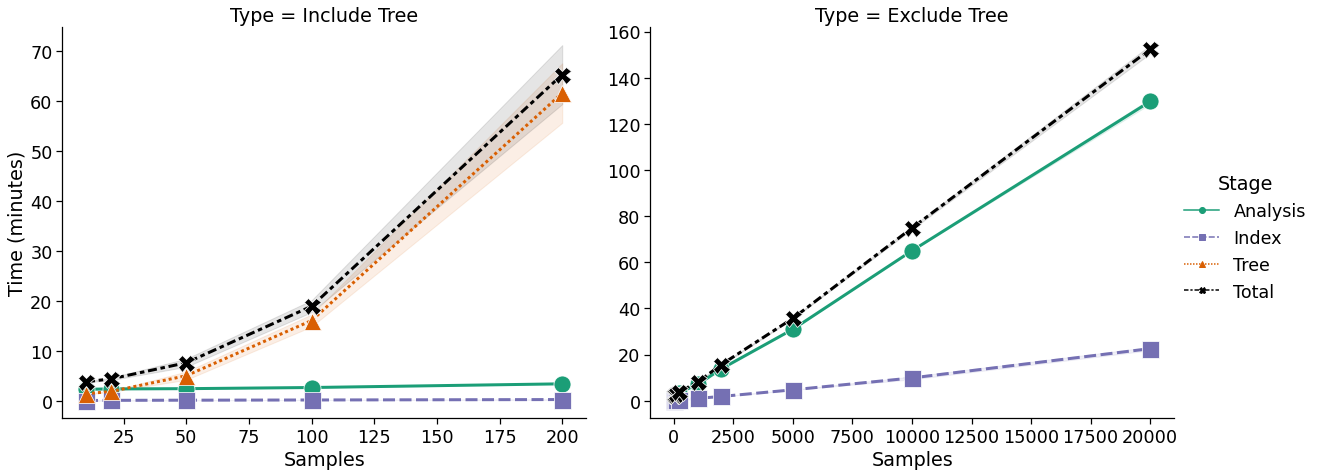

In [6]:
with sns.plotting_context("notebook", font_scale=1.6):
    g = sns.relplot(x='Samples', y='Time (minutes)', hue="Stage", style="Stage", ci="sd", kind="line",
                    data=index_info_runtime_df, col="Type", markers=stages_markers, estimator='mean',
                    height=7, aspect=1.2, linewidth=3, markersize=17, err_kws={"alpha": 0.1},
                    palette=stages_palette,
                    facet_kws={'sharey': False, 'sharex': False})
    plt.savefig('figures/index-runtime.pdf')

### 2.1.3. Analysis memory plots

In [7]:
def melt_memory(df: pd.DataFrame, include_tree_na: bool, id_vars: str) -> pd.DataFrame:
    if include_tree_na:
        df = df[~df['Tree memory (max)'].isna()]
        value_vars = ['Analysis memory (max)', 'Index memory (max)', 'Tree memory (max)']
    else:
        value_vars = ['Analysis memory (max)', 'Index memory (max)']

    df = pd.melt(df, id_vars=id_vars,
            value_vars=value_vars)
    df['value'] = df['value'].apply(lambda x: x/(1024**3))
    df = df.rename({'variable': 'Stage', 'value': 'Peak Memory (GB)'}, axis='columns')
    df['Stage'] = df['Stage'].str.replace(' memory (max)', '', regex=False)
    return df

In [8]:
index_info_memory_df = melt_and_combine_with_without_tree(index_info_df,
                                                          melt_func=melt_memory,
                                                          id_vars='Samples')
index_info_memory_df

,Samples,Stage,Peak Memory (GB),Type
0,10,Analysis,1.331505,Include Tree
1,10,Analysis,1.348621,Include Tree
2,10,Analysis,1.345543,Include Tree
3,20,Analysis,1.691032,Include Tree
4,20,Analysis,1.555649,Include Tree
...,...,...,...,...
55,10000,Index,27.548969,Exclude Tree
56,10000,Index,27.235210,Exclude Tree
57,20000,Index,33.660168,Exclude Tree
58,20000,Index,33.647835,Exclude Tree


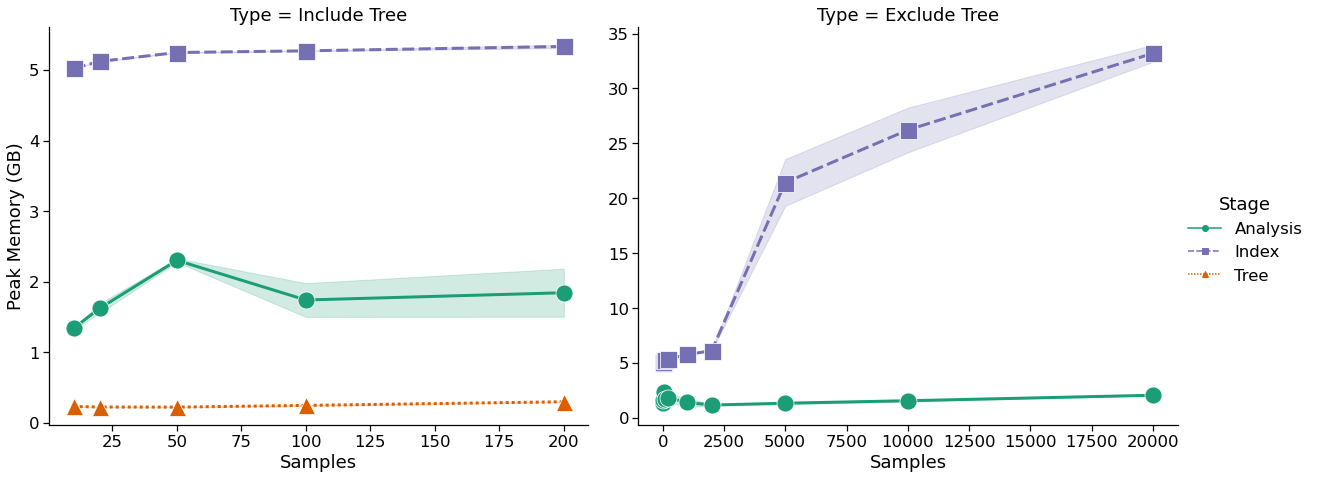

In [9]:
with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.relplot(x='Samples', y='Peak Memory (GB)', hue="Stage", style="Stage", ci="sd", kind="line",
                    data=index_info_memory_df, markers=stages_markers_nototal, estimator='mean', col="Type",
                    height=7, aspect=1.2, linewidth=3, markersize=17, err_kws={"alpha": 0.2},
                    palette=stages_palette_nototal,
                    facet_kws={'sharey': False, 'sharex': False})
    plt.savefig('figures/index-memory.pdf')

#### 2.1.3.1. Number of features vs memory

In [10]:
# memory_features_df = melt_memory(index_info_df,
#                                             include_tree_na=False,
#                                             id_vars=['Samples',
#                                                      'Number features (no unknown)'])
# memory_features_df = memory_features_df.rename({'Number features (no unknown)': 'Number of features'}, axis='columns')
# memory_features_df['Feature Type'] = 'Variant calls'

memory_unknown_features_df = melt_memory(index_info_df,
                                            include_tree_na=False,
                                            id_vars=['Samples',
                                                     'Number features (unknown)'])
memory_unknown_features_df = memory_unknown_features_df.rename({'Number features (unknown)': 'Number of features'}, axis='columns')
memory_unknown_features_df['Feature Type'] = 'Unknown/missing'

memory_all_features_df = melt_memory(index_info_df,
                                            include_tree_na=False,
                                            id_vars=['Samples',
                                                     'Number features (all)'])
memory_all_features_df = memory_all_features_df.rename({'Number features (all)': 'Number of features'}, axis='columns')
memory_all_features_df['Feature Type'] = 'All'

memory_features_combined_df = pd.concat([memory_unknown_features_df, memory_all_features_df])
memory_features_combined_df = memory_features_combined_df[memory_features_combined_df['Stage'] == 'Index']
memory_features_combined_df['Number of samples'] = memory_features_combined_df['Samples']
memory_features_combined_df.loc[memory_features_combined_df['Samples'] <= 2000, 'Number of samples'] = '≤ 2000'

memory_features_combined_df.tail(10)

,Samples,Number of features,Stage,Peak Memory (GB),Feature Type,Number of samples
50,2000,32480,Index,6.111019,All,≤ 2000
51,5000,35646,Index,20.335629,All,5000
52,5000,35646,Index,20.074112,All,5000
53,5000,35646,Index,23.888672,All,5000
54,10000,39068,Index,23.872482,All,10000
55,10000,39068,Index,27.548969,All,10000
56,10000,39068,Index,27.235210,All,10000
57,20000,45667,Index,33.660168,All,20000
58,20000,45667,Index,33.647835,All,20000
59,20000,45667,Index,32.315666,All,20000


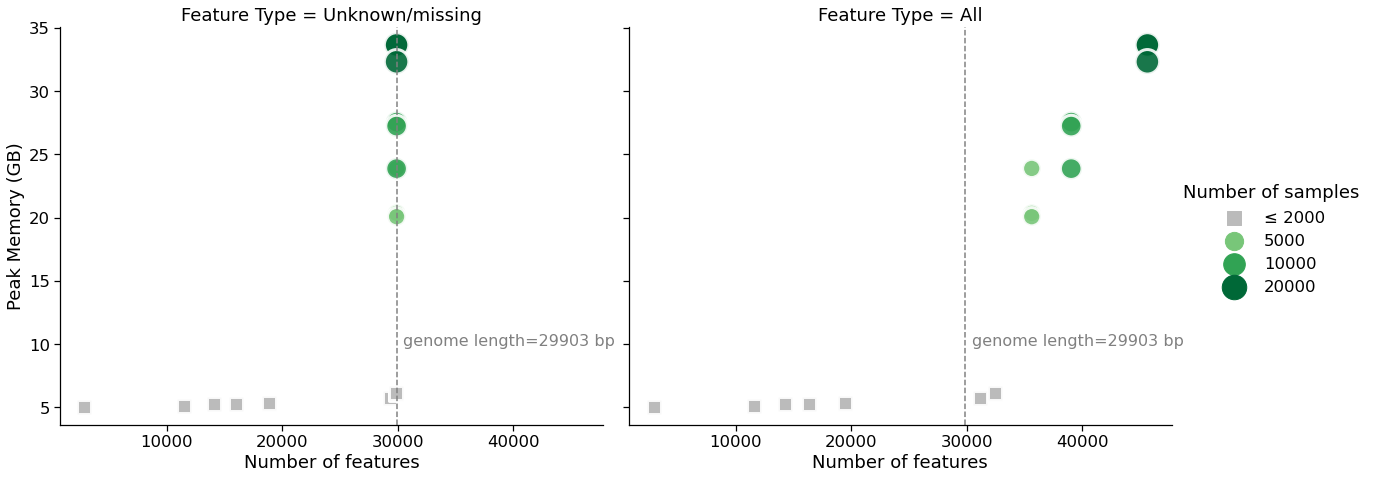

In [11]:
with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.relplot(x='Number of features', y='Peak Memory (GB)', col="Feature Type",
                    size='Number of samples', style='Number of samples',
                    kind="scatter", s=100, alpha=0.9, hue='Number of samples',
                    sizes=(600, 200), palette=['#bbbbbb', '#78c679', '#31a354', '#006837'],
                    data=memory_features_combined_df, markers=["s", "o", "o", "o"],
                    height=7, aspect=1.2, linewidth=3,
                    )
    
    reference_size = index_info_df['Reference length'].value_counts().index[0]
    for ax in g.axes.flat:
        ax.axvline(reference_size, color='gray', ls='--')
        ylim = ax.get_ylim()
        ylen = ylim[1] - ylim[0]
        ypos = ylim[1] - ylen * 0.8
        xpos = reference_size + reference_size * 0.02
        ax.text(xpos, ypos, f'genome length={reference_size} bp', fontdict={'size': 16, 'color': 'gray'})
        
    plt.savefig('figures/index-memory-features.pdf')

### 2.1.4. Disk usage plots

In [12]:
def melt_disk_usage(df: pd.DataFrame, id_vars: str) -> pd.DataFrame:
    df = df.copy()
    df['Total size'] = df['Analysis disk uage'] + df['Index size']
    df = pd.melt(df, id_vars=id_vars,
            value_vars=['Analysis disk uage', 'Index size', 'Total size'])
    df['value'] = df['value'].apply(lambda x: x/(1024**3))
    df = df.rename({'variable': 'Stage', 'value': 'Disk (GB)'}, axis='columns')
    df['Stage'] = df['Stage'].str.replace(' disk uage', '', regex=False)
    df['Stage'] = df['Stage'].str.replace(' size', '', regex=False)
    return df
index_info_disk_df = melt_disk_usage(index_info_df, id_vars='Samples')
index_info_disk_df.head(3)

,Samples,Stage,Disk (GB)
0,10,Analysis,3.214535
1,10,Analysis,3.214535
2,10,Analysis,3.214535


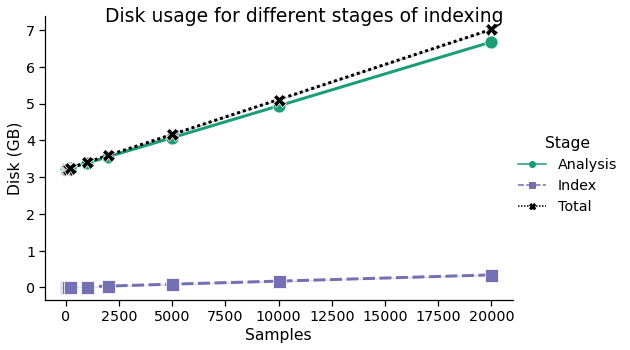

In [13]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Samples', y='Disk (GB)', hue="Stage", style="Stage", ci="sd", kind="line",
                    data=index_info_disk_df, markers=stages_markers_notree, estimator='mean',
                    palette=stages_palette_notree,
                    height=5, aspect=1.5, linewidth=3, markersize=13, err_kws={"alpha": 0.2})
    g.fig.suptitle("Disk usage for different stages of indexing")
    plt.savefig('figures/index-disk-usage.pdf')

# 3. Querying

## 3.1. Querying API

In [14]:
query_paths = [x / 'query-api.tsv' for x in cases_paths]
query_paths = [x for x in query_paths if x.exists()]

query_df = read_all_df(query_paths)
query_df['Samples'] = query_df['Name'].str.extract(r'^case-(\d+)').astype(int)
query_df['Time'] = query_df['Time'].apply(lambda x: x * 1000)
query_df['Number of features (thousands)'] = query_df['Number features (all)'] / 1000
query_df = query_df.rename({'Time': 'Time (ms)'}, axis='columns')

# Remove isin queries to ignore queries involving a tree
query_df = query_df[~query_df['Kind'].str.contains('isin')]

# Remove db.samples_query since I don't really need the times
query_df = query_df[~query_df['Kind'].str.contains('db.samples_query')]

# Divide up kinds of queries into classes
query_df['Time scale'] = 'Short'
query_df.loc[query_df['Kind'].isin(
    ['q.toframe', 'q.hasa', 'q.join', 'q.features_summary']), 'Time scale'] = 'Medium'
query_df.loc[query_df['Kind'].isin(
    ['q.features_comparison']), 'Time scale'] = 'Long'

query_df = query_df.sort_values('Time scale', ascending=False)

query_df.head(5)

,Name,Kind,Number samples,Number features (no unknown),Number features (all),Number executions,Iteration,Time (ms),Samples,Number of features (thousands),Time scale
999,case-20000,q.summary,20000,15764,45667,500,10,0.497406,20000,45.667,Short
388,case-100,q.isa,100,374,16351,500,9,0.553504,100,16.351,Short
386,case-100,q.isa,100,374,16351,500,7,0.562264,100,16.351,Short
385,case-100,q.isa,100,374,16351,500,6,0.668586,100,16.351,Short
384,case-100,q.isa,100,374,16351,500,5,0.617167,100,16.351,Short


### 3.1.1. Compare runtime for single set of samples

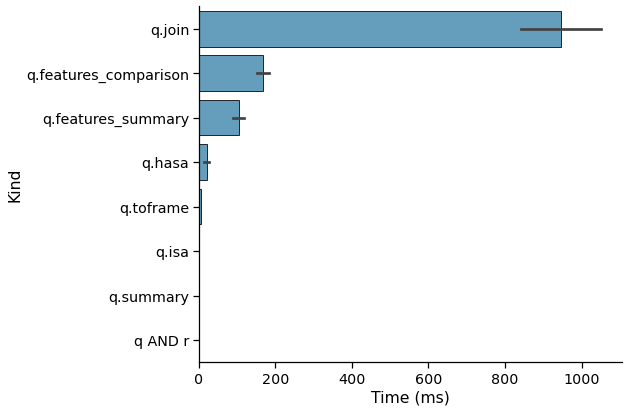

In [15]:
query_samples = query_df[query_df['Samples'] == 100]
query_samples = query_samples.sort_values('Time (ms)', ascending=False)
query_samples

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(
        data=query_samples, kind="bar",
        y="Kind", x="Time (ms)", hue=None,
        ci="sd", height=6, aspect=1.5, alpha=0.8, color="#2b8cbe", edgecolor="black"
    )

### 3.1.2. Compare runtime vs. all samples

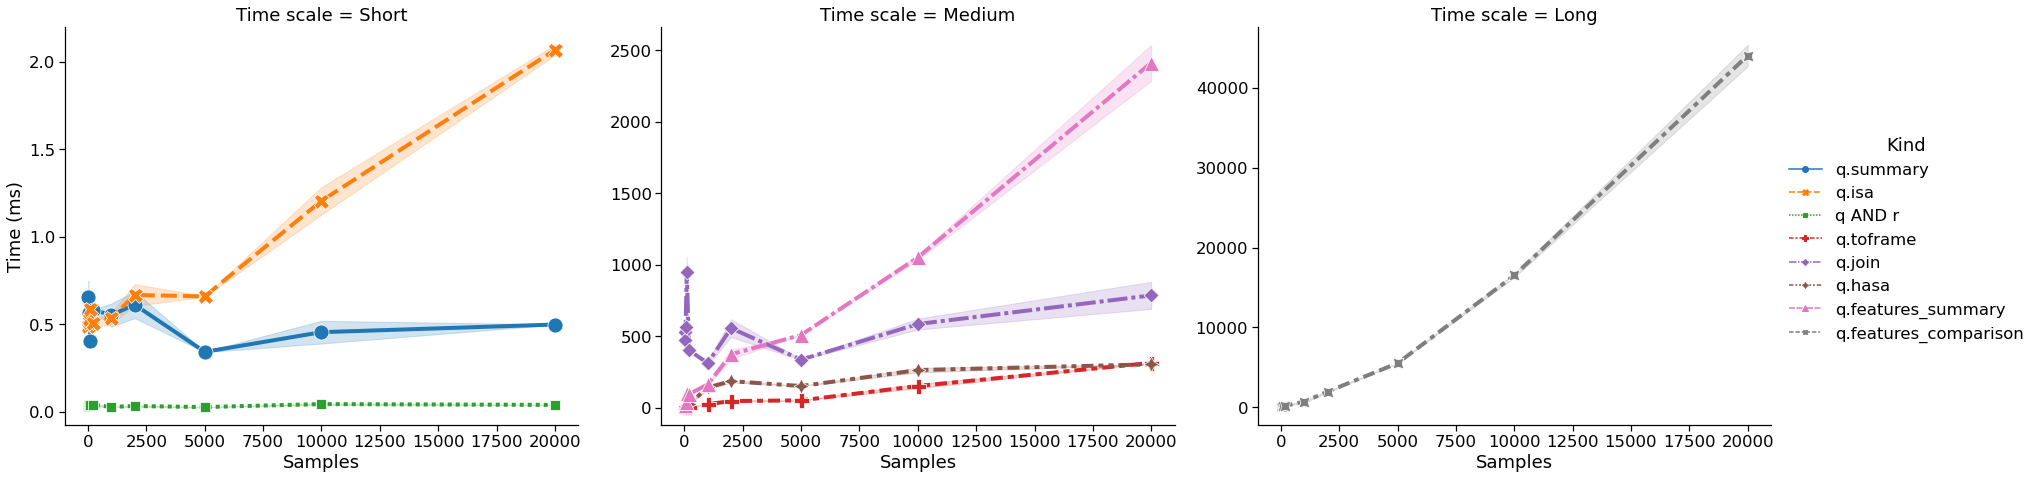

In [16]:
with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.relplot(x='Samples', y='Time (ms)', hue="Kind", style="Kind", ci="sd", kind="line",
                    data=query_df, markers=True, estimator='mean', col="Time scale",
                    height=7, aspect=1.2, linewidth=4, markersize=15, err_kws={"alpha": 0.2},
                    facet_kws={'sharey': False, 'sharex': True})

### 3.1.3. Compare runtime vs. number of features

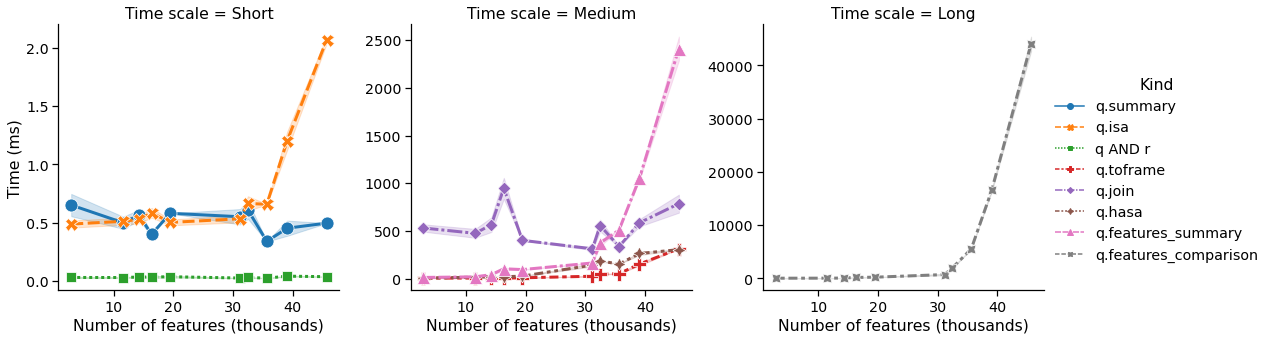

In [17]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Number of features (thousands)', y='Time (ms)', hue="Kind", style="Kind",
                    ci="sd", kind="line",
                    data=query_df, markers=True, estimator='mean', col="Time scale",
                    height=5, aspect=1, linewidth=3, markersize=13, err_kws={"alpha": 0.2},
                    facet_kws={'sharey': False, 'sharex': True})

## 3.2. Querying CLI

In [18]:
query_paths_cli = [x / 'query-cli.tsv' for x in cases_paths]
query_paths_cli = [x for x in query_paths_cli if x.exists()]
query_cli_df = read_all_df(query_paths_cli)
query_cli_df['Samples'] = query_cli_df['Name'].str.extract(r'^case-(\d+)').astype(int)
query_cli_df['Time (ms)'] = query_cli_df['Runtime'].apply(lambda x: x * 1000)
query_cli_df['Memory (MB)'] = query_cli_df['Memory (max)'].apply(lambda x: x / (1024**2))
query_cli_df['Number of features (thousands)'] = query_cli_df['Number features (all)'] / 1000
query_cli_df['Number of unknown features (thousands)'] = (query_cli_df['Number features (all)'] - \
                                                          query_cli_df['Number features (no unknown)']) / 1000

# Remove isin queries to ignore queries involving a tree
query_cli_df = query_cli_df[~query_cli_df['Kind'].str.contains('isin')]

query_cli_df.head(5)

,Name,Kind,Iteration,Number samples,Number features (no unknown),Number features (all),Runtime,Memory (max),Mmemory (max/process),Samples,Time (ms),Memory (MB),Number of features (thousands),Number of unknown features (thousands)
0,case-10,query hasa,1,10,44,2900,3.90,220303360.0,220303360.0,10,3900.0,210.097656,2.9,2.856
1,case-10,query hasa,2,10,44,2900,4.33,219697152.0,219697152.0,10,4330.0,209.519531,2.9,2.856
2,case-10,query hasa,3,10,44,2900,4.41,220516352.0,220516352.0,10,4410.0,210.300781,2.9,2.856
3,case-10,query hasa,4,10,44,2900,4.47,220147712.0,220147712.0,10,4470.0,209.949219,2.9,2.856
4,case-10,query hasa,5,10,44,2900,4.48,220086272.0,220086272.0,10,4480.0,209.890625,2.9,2.856


### 3.2.1. Compare runtime for single set of samples

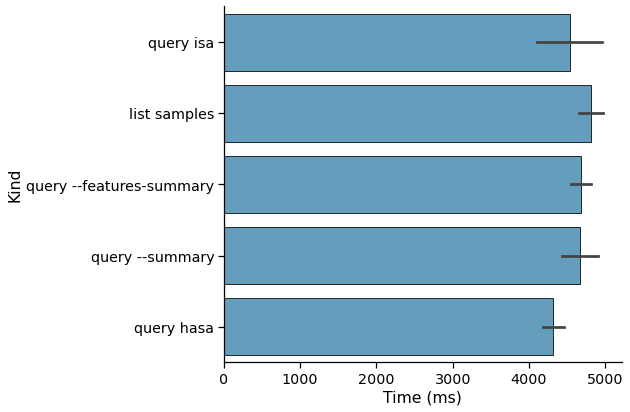

In [19]:
query_cli_samples = query_cli_df[query_cli_df['Samples'] == 100]
query_cli_samples = query_cli_samples.sort_values('Time (ms)', ascending=False)

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(data=query_cli_samples, kind="bar",
                  y="Kind", x="Time (ms)", hue=None,
                  ci="sd", height=6, aspect=1.5, alpha=0.8,
                  color="#2b8cbe", edgecolor="black")

#### 3.2.1.1. Compare runtime between CLI and API

In [20]:
qcli = query_cli_samples.loc[:, ['Name', 'Kind', 'Number samples', 'Time (ms)']]
qcli['Kind'] = qcli['Kind'].replace({
        'query isa': 'isa',
        'query hasa': 'hasa',
        'query isin': 'isin',
        'query --features-summary': 'features summary',
    })
qcli['Method'] = 'CLI'
qapi = query_samples.loc[:, ['Name', 'Kind', 'Number samples', 'Time (ms)']]
qapi['Kind'] = qapi['Kind'].replace({
        'q.isa': 'isa',
        'q.hasa': 'hasa',
        'q.isin': 'isin',
        'q.features_summary': 'features summary',
    })
qapi['Method'] = 'API'

q_cli_api = pd.concat([qcli, qapi])
q_cli_api = q_cli_api[q_cli_api['Kind'].isin(['isa', 'hasa', 'isin', 'features summary'])]
q_cli_api = q_cli_api.sort_values(['Time (ms)'])
q_cli_api.head(3)

,Name,Kind,Number samples,Time (ms),Method
387,case-100,isa,100,0.536705,API
388,case-100,isa,100,0.553504,API
383,case-100,isa,100,0.556917,API


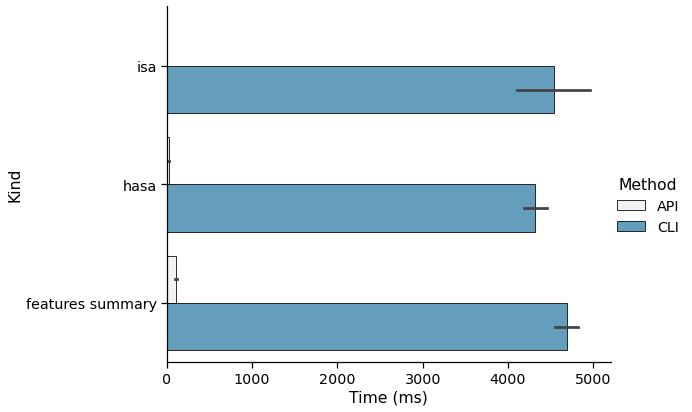

In [21]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(data=q_cli_api, kind="bar",
                  y="Kind", x="Time (ms)", hue='Method',
                  ci="sd", height=6, aspect=1.5, alpha=0.8,
                  color="#2b8cbe", edgecolor="black")

### 3.2.2. Compare runtime to number of samples

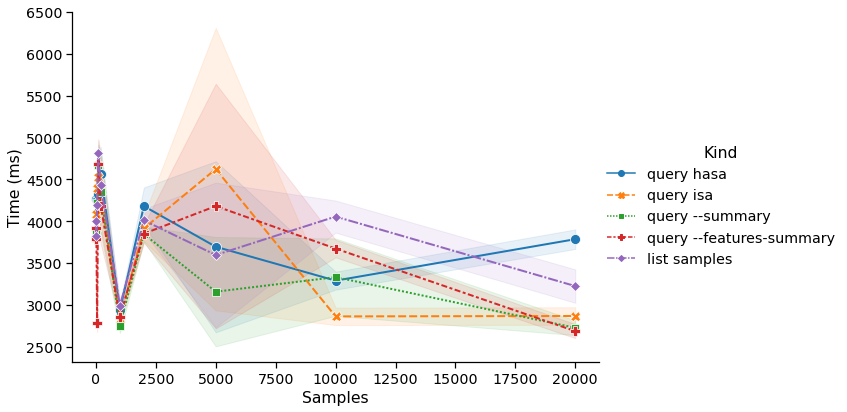

In [22]:
# with sns.plotting_context("notebook", font_scale=1.3):
#     g = sns.relplot(x='Samples', y='Time (ms)', col="Kind", ci="sd", kind="line",
#                     data=query_cli_df, marker="o", estimator='mean',
#                     facet_kws={'sharey': True, 'sharex': True}, col_wrap=3, height=5)
    
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Samples', y='Time (ms)', hue="Kind", ci="sd", kind="line",
                    data=query_cli_df, style="Kind", markers=True, estimator='mean',
                    height=6, aspect=1.5, linewidth=2, markersize=10, err_kws={"alpha": 0.1})

### 3.2.3. Compare peak memory to number of samples

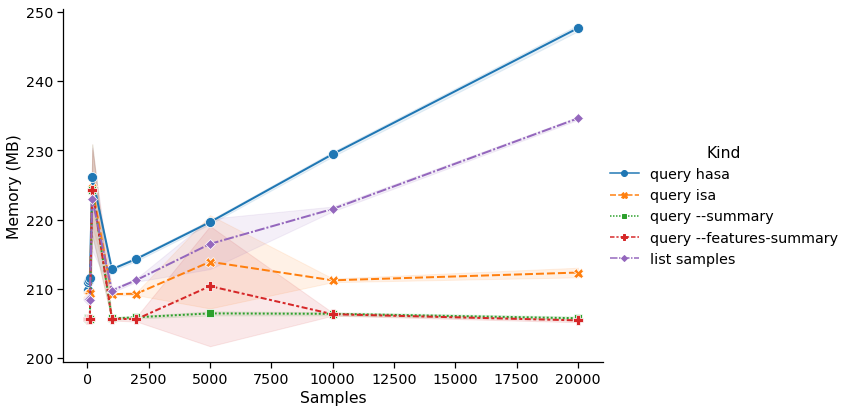

In [23]:
# with sns.plotting_context("notebook", font_scale=1.3):
#     g = sns.relplot(x='Samples', y='Memory (MB)', col="Kind", ci="sd", kind="line",
#                     data=query_cli_df, marker="o", estimator='mean',
#                     facet_kws={'sharey': True, 'sharex': True}, col_wrap=3, height=5)
    
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Samples', y='Memory (MB)', hue="Kind", style="Kind", ci="sd", kind="line",
                    data=query_cli_df, markers=True, estimator='mean',
                    height=6, aspect=1.5, linewidth=2, markersize=10, err_kws={"alpha": 0.1})

### 3.2.4. Compare runtime to number of features

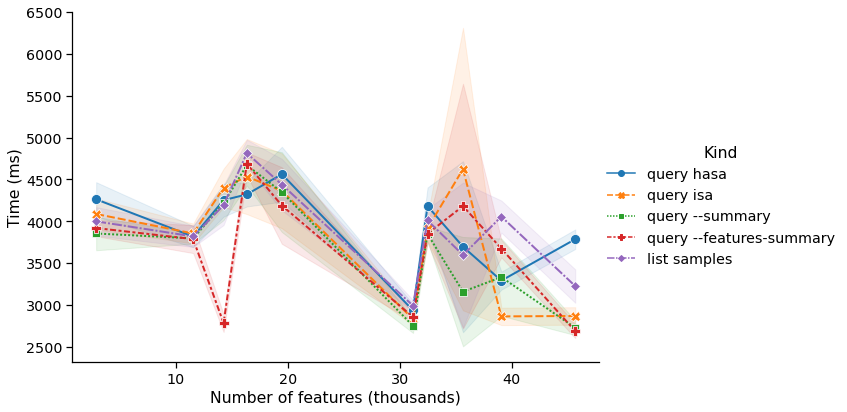

In [24]:
# with sns.plotting_context("notebook", font_scale=1.3):
#     g = sns.relplot(x='Number of features (thousands)', y='Time (ms)', col="Kind", ci="sd", kind="line",
#                     data=query_cli_df, marker="o", estimator='mean',
#                    facet_kws={'sharey': True, 'sharex': True}, col_wrap=3, height=5)
    
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Number of features (thousands)', y='Time (ms)', hue="Kind", ci="sd", kind="line",
                    data=query_cli_df, markers=True, estimator='mean', style="Kind",
                   height=6, aspect=1.5, linewidth=2, markersize=10, err_kws={"alpha": 0.1})

### 3.2.5. Compare peak memory to number of features

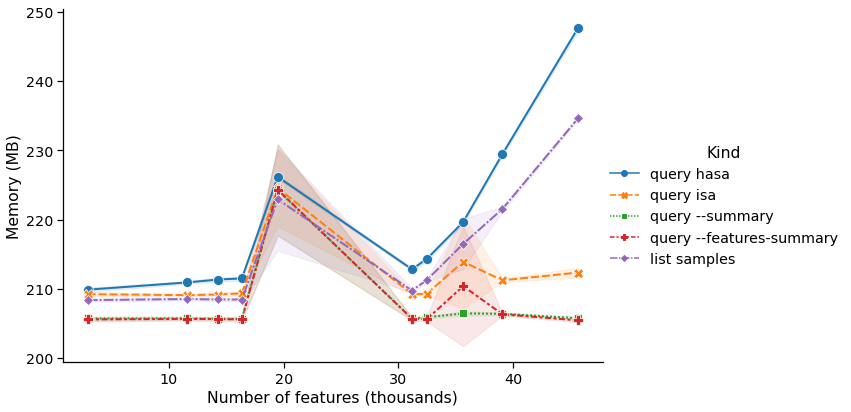

In [25]:
# with sns.plotting_context("notebook", font_scale=1.3):
#     g = sns.relplot(x='Number of features (thousands)', y='Memory (MB)', col="Kind", ci="sd", kind="line",
#                     data=query_cli_df, marker="o", estimator='mean',
#                    facet_kws={'sharey': True, 'sharex': True}, col_wrap=3, height=5)
    
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Number of features (thousands)', y='Memory (MB)', hue="Kind", ci="sd", kind="line",
                    data=query_cli_df, markers=True, estimator='mean', style="Kind",
                   height=6, aspect=1.5, linewidth=2, markersize=10, err_kws={"alpha": 0.1})

# 4. Tree vs. clustering

## 4.1. Connect to index and metadata file

In [51]:
import genomics_data_index.api as gdi

number_samples = 200
min_samples_cluster = 2

clustering_index = cases_root_dir / f'case-{number_samples}' / 'index'
db = gdi.GenomicsDataIndex.connect(clustering_index)
db

Attempting to set global database_path_translator=<genomics_data_index.storage.model.db.DatabasePathTranslator.DatabasePathTranslator object at 0x7fe255a44220> but it is already set


<GenomicsDataIndex(samples=200)>

In [52]:
import pandas as pd

metadata_df = pd.read_csv(metadata_file, sep='\t')
metadata_df.head(2)

,strain,virus,gisaid_epi_isl,genbank_accession,sra_accession,date,region,country,division,location,...,ambiguity_score,scorpio_call,scorpio_support,scorpio_conflict,version,pangolin_version,pangoLEARN_version,pango_version,status,note
0,OU420663,ncov,?,OU420663,ERR5939958,2020,Europe,United Kingdom,England,NaN,...,1.00000,Alpha (B.1.1.7-like),1.0,0.0,PLEARN-v1.2.66,3.1.11,2021-08-24,v1.2.66,passed_qc,scorpio call: Alt alleles 23; Ref alleles 0; A...
1,USA/NY-CUIMC-NP-3606/2020,ncov,?,MZ702266,NaN,2020-12-02,North America,USA,New York,New York City,...,0.95097,NaN,NaN,NaN,PLEARN-v1.2.66,3.1.11,2021-08-24,v1.2.66,passed_qc,NaN


In [53]:
metadata_df.columns

Index(['strain', 'virus', 'gisaid_epi_isl', 'genbank_accession',
       'sra_accession', 'date', 'region', 'country', 'division', 'location',
       'region_exposure', 'country_exposure', 'division_exposure', 'segment',
       'length', 'host', 'age', 'sex', 'Nextstrain_clade', 'pango_lineage',
       'GISAID_clade', 'originating_lab', 'submitting_lab', 'authors', 'url',
       'title', 'paper_url', 'date_submitted', 'sampling_strategy',
       'missing_data', 'divergence', 'nonACGTN', 'rare_mutations',
       'snp_clusters', 'QC_missing_data', 'QC_mixed_sites',
       'QC_rare_mutations', 'QC_snp_clusters', 'clock_deviation',
       'missing_data_percent', 'taxon', 'lineage', 'conflict',
       'ambiguity_score', 'scorpio_call', 'scorpio_support',
       'scorpio_conflict', 'version', 'pangolin_version', 'pangoLEARN_version',
       'pango_version', 'status', 'note'],
      dtype='object')

In [54]:
metadata_df['lineage'].value_counts()

B.1.1.7      42124
AY.4         11346
B.1.617.2     5418
B.1.2         4171
B.1.177       2838
             ...  
B.1.1.56         1
B.1.581          1
B.1.1.242        1
B.1.1.380        1
L.2              1
Name: lineage, Length: 869, dtype: int64

## 4.2. Initiate query

In [55]:
q = db.samples_query(reference_name='NC_045512', universe='mutations').set_outgroup('NC_045512')\
      .join(metadata_df, sample_names_column='strain')
q

<MutationTreeSamplesQuery[selected=100% (200/200) samples, unknown=0% (0/200) samples]>

## 4.3. Look at what lineages are available

In [56]:
q.toframe()['lineage'].value_counts()

B.1           35
B.1.1         19
B.1.1.39      13
B.1.177       12
B.1.160       12
D.2           10
C.35           9
B.1.177.23     8
B.1.1.70       8
B.1.177.44     7
B.1.367        6
B.1.258        5
B.1.236        5
B              3
A.1            3
B.1.146        3
B.1.1.153      2
B.1.520        2
B.1.1.372      2
B.1.416.1      2
B.1.22         2
B.1.160.32     2
B.1.9.5        2
B.1.1.7        1
B.1.177.43     1
B.3            1
B.1.91         1
B.1.1.37       1
B.1.221        1
B.1.1.232      1
A              1
B.1.1.277      1
B.40           1
B.1.1.218      1
B.1.157        1
B.1.160.14     1
B.1.258.9      1
B.1.1.242      1
B.1.1.47       1
B.1.1.58       1
B.1.8          1
B.1.1.521      1
C.30           1
B.1.220        1
B.1.1.406      1
B.31           1
B.1.36         1
B.1.160.16     1
B.1.389        1
B.1.356        1
B.1.400        1
Name: lineage, dtype: int64

## 4.4. Cluster scoring (ML tree)

In [57]:
from genomics_data_index.api.query.impl.ClusterScorer import ClusterScorer

scorer = ClusterScorer(q)
scorer

In [58]:
scores_ml = scorer.score_groupby(groupby_column='lineage', min_samples_count=min_samples_cluster)
scores_ml['Score (ML)'] = scores_ml['Score']
scores_ml

,Score,Sample Count,Score (ML)
lineage,,,
A.1,1.000000,3,1.000000
B,0.015000,3,0.015000
B.1,0.175000,35,0.175000
B.1.1,0.380000,19,0.380000
B.1.1.153,1.000000,2,1.000000
B.1.1.372,1.000000,2,1.000000
B.1.1.39,1.000000,13,1.000000
B.1.1.70,1.000000,8,1.000000
B.1.146,1.000000,3,1.000000


## 4.5. Cluster scoring (kmer trees)

### 4.5.1. Build and score 31-mer tree

In [59]:
from ete3 import Tree, ClusterTree

# Used due to a bug in the software which uses the original filenames as names in the tree instead
# of the sample names. This can be removed when the bug is fixed.
def fix_kmer_tree_names(tree: Tree) -> Tree:
    newick_str = tree.write()
    newick_fixed = newick_str.replace('__','/')
            
    return ClusterTree(newick_fixed)

In [60]:
q31 = db.samples_query().build_tree(kind='kmer', kmer_size=31)\
        .join(metadata_df, sample_names_column='strain')
q31._tree = fix_kmer_tree_names(q31.tree)
q31

<KmerTreeSamplesQuery[selected=100% (200/200) samples, unknown=0% (0/200) samples]>

In [61]:
score_kmer_31 = ClusterScorer(q31).score_groupby(groupby_column='lineage',
                                                 min_samples_count=min_samples_cluster)
score_kmer_31['Score (kmer=31)'] = score_kmer_31['Score']
score_kmer_31

,Score,Sample Count,Score (kmer=31)
lineage,,,
A.1,0.039474,3,0.039474
B,0.015306,3,0.015306
B.1,0.181347,35,0.181347
B.1.1,0.095960,19,0.095960
B.1.1.153,0.011429,2,0.011429
B.1.1.372,0.010811,2,0.010811
B.1.1.39,0.072626,13,0.072626
B.1.1.70,0.043478,8,0.043478
B.1.146,0.015464,3,0.015464


### 4.5.2. Build and score 51-mer tree

In [62]:
q51 = db.samples_query().build_tree(kind='kmer', kmer_size=51)\
        .join(metadata_df, sample_names_column='strain')
q51._tree = fix_kmer_tree_names(q51.tree)
q51

<KmerTreeSamplesQuery[selected=100% (200/200) samples, unknown=0% (0/200) samples]>

In [63]:
score_kmer_51 = ClusterScorer(q51).score_groupby(groupby_column='lineage',
                                                 min_samples_count=min_samples_cluster)
score_kmer_51['Score (kmer=51)'] = score_kmer_51['Score']
score_kmer_51

,Score,Sample Count,Score (kmer=51)
lineage,,,
A.1,1.000000,3,1.000000
B,0.015385,3,0.015385
B.1,0.175879,35,0.175879
B.1.1,0.098446,19,0.098446
B.1.1.153,1.000000,2,1.000000
B.1.1.372,0.010204,2,0.010204
B.1.1.39,0.067010,13,0.067010
B.1.1.70,0.043243,8,0.043243
B.1.146,0.016393,3,0.016393


### 4.5.2. Build and score 71-mer tree

In [64]:
q71 = db.samples_query().build_tree(kind='kmer', kmer_size=71)\
        .join(metadata_df, sample_names_column='strain')
q71._tree = fix_kmer_tree_names(q71.tree)
q71

<KmerTreeSamplesQuery[selected=100% (200/200) samples, unknown=0% (0/200) samples]>

In [65]:
score_kmer_71 = ClusterScorer(q71).score_groupby(groupby_column='lineage',
                                                 min_samples_count=min_samples_cluster)
score_kmer_71['Score (kmer=71)'] = score_kmer_71['Score']
score_kmer_71

,Score,Sample Count,Score (kmer=71)
lineage,,,
A.1,0.022901,3,0.022901
B,0.015075,3,0.015075
B.1,0.188172,35,0.188172
B.1.1,0.104972,19,0.104972
B.1.1.153,0.019231,2,0.019231
B.1.1.372,0.011299,2,0.011299
B.1.1.39,0.071038,13,0.071038
B.1.1.70,0.041237,8,0.041237
B.1.146,0.016216,3,0.016216


## 4.6. Plot cluster scores

In [66]:
scores_df = scores_ml.copy().drop(['Score'], axis='columns')
for other_df in [score_kmer_31, score_kmer_51, score_kmer_71]:
    other_df = other_df.drop(['Score', 'Sample Count'], axis='columns')
    scores_df = scores_df.merge(other_df, left_index=True, right_index=True)
scores_df = scores_df.reset_index()
scores_df

,lineage,Sample Count,Score (ML),Score (kmer=31),Score (kmer=51),Score (kmer=71)
0,A.1,3,1.000000,0.039474,1.000000,0.022901
1,B,3,0.015000,0.015306,0.015385,0.015075
2,B.1,35,0.175000,0.181347,0.175879,0.188172
3,B.1.1,19,0.380000,0.095960,0.098446,0.104972
4,B.1.1.153,2,1.000000,0.011429,1.000000,0.019231
5,B.1.1.372,2,1.000000,0.010811,0.010204,0.011299
6,B.1.1.39,13,1.000000,0.072626,0.067010,0.071038
7,B.1.1.70,8,1.000000,0.043478,0.043243,0.041237
8,B.1.146,3,1.000000,0.015464,0.016393,0.016216
9,B.1.160,12,0.800000,0.063492,0.082192,0.068966


In [67]:
scores_long_df = pd.melt(scores_df, id_vars='lineage',
                         value_vars=['Score (ML)', 'Score (kmer=31)', 'Score (kmer=51)', 'Score (kmer=71)'])
scores_long_df = scores_long_df.rename({'lineage': 'Lineage', 'variable': 'Method', 'value': 'Score'}, axis='columns')
scores_long_df.head(3)

,Lineage,Method,Score
0,A.1,Score (ML),1.000
1,B,Score (ML),0.015
2,B.1,Score (ML),0.175


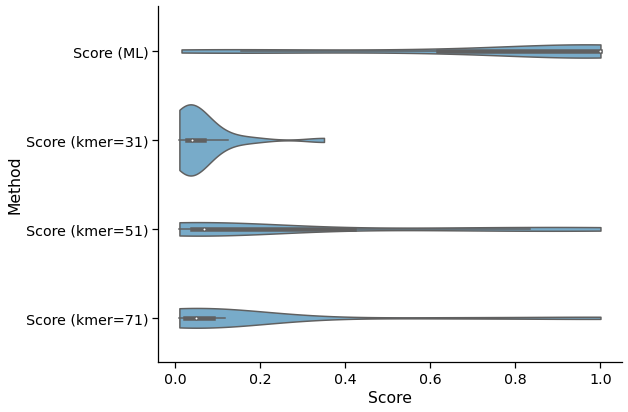

In [68]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(data=scores_long_df, kind="violin",
                    y="Method", x="Score", hue=None,
                    scale='area', inner='box',
                    ci=None, height=6, aspect=1.5,
                    cut=0,
                    color="#6baed6", edgecolor="black")

## 4.7 Visualize clusters

In [69]:
top_lineages_ml = scores_df.sort_values('Score (ML)', ascending=False).head(5)
top_lineages_ml

,lineage,Sample Count,Score (ML),Score (kmer=31),Score (kmer=51),Score (kmer=71)
0,A.1,3,1.0,0.039474,1.000000,0.022901
8,B.1.146,3,1.0,0.015464,0.016393,0.016216
21,C.35,9,1.0,0.045685,0.045000,0.048128
20,B.1.9.5,2,1.0,0.031250,1.000000,0.666667
15,B.1.236,5,1.0,0.029070,0.027174,0.035461


### 4.7.1. Visualize top ML scores

#### 4.7.1.1. On ML tree

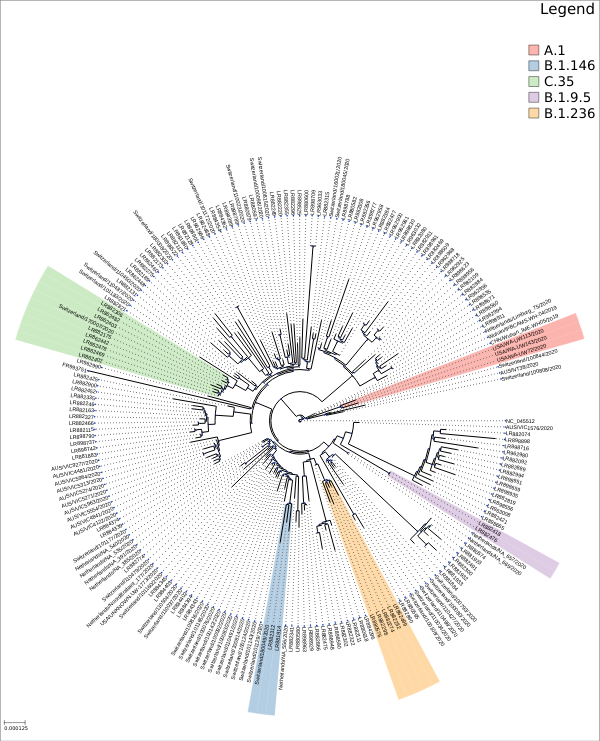

In [70]:
ts = q.tree_styler(mode='c', annotate_box_width=24, legend_nsize=24, legend_fsize=24,
                   annotate_opacity_absent=1.0,
                   legend_type_label_present='', legend_type_label_unknown='',
                   legend_title='Legend', annotate_show_box_label=False,
                   include_unknown=False, annotate_color_unknown='black',
                   tree_scale=400000,
                  )
for lineage in top_lineages_ml['lineage'].tolist():
    ts = ts.highlight(q.isa(lineage, isa_column='lineage', kind='dataframe'), legend_label=lineage)
ts.render(w=600)

#### 4.7.1.2. On kmer=31 tree

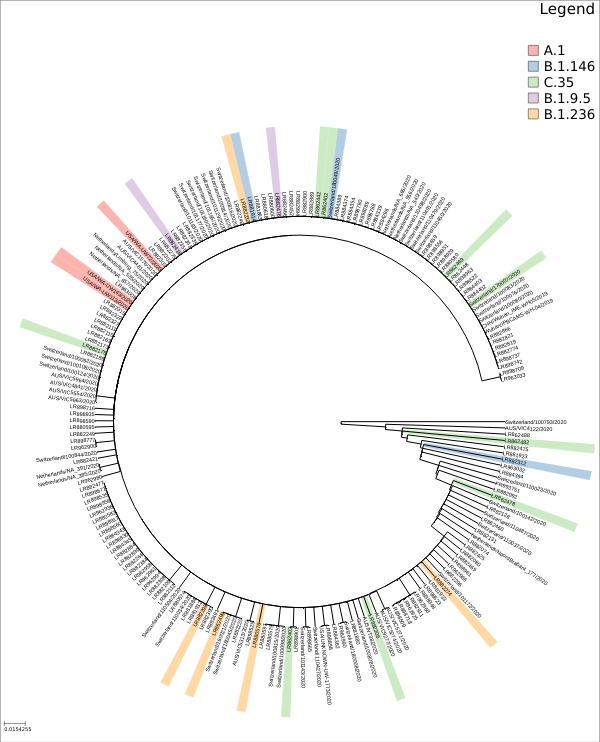

In [71]:
ts31 = q31.tree_styler(mode='c', annotate_box_width=24, legend_nsize=24, legend_fsize=24,
                   annotate_opacity_absent=1.0,
                   legend_type_label_present='', legend_type_label_unknown='',
                   legend_title='Legend', annotate_show_box_label=False,
                   include_unknown=False, annotate_color_unknown='black')
for lineage in top_lineages_ml['lineage'].tolist():
    ts31 = ts31.highlight(q.isa(lineage, isa_column='lineage', kind='dataframe'), legend_label=lineage)
ts31.render(w=600)

### 4.7.2. Visualize top kmer=31 scores

#### 4.7.2.1. On kmer=31 tree

In [72]:
top_lineages_k31 = scores_df.sort_values('Score (kmer=31)', ascending=False).head(5)
top_lineages_k31

,lineage,Sample Count,Score (ML),Score (kmer=31),Score (kmer=51),Score (kmer=71)
13,B.1.177.44,7,1.000000,0.350000,0.700000,0.063636
2,B.1,35,0.175000,0.181347,0.175879,0.188172
18,B.1.416.1,2,0.666667,0.125000,0.038462,0.117647
3,B.1.1,19,0.380000,0.095960,0.098446,0.104972
6,B.1.1.39,13,1.000000,0.072626,0.067010,0.071038


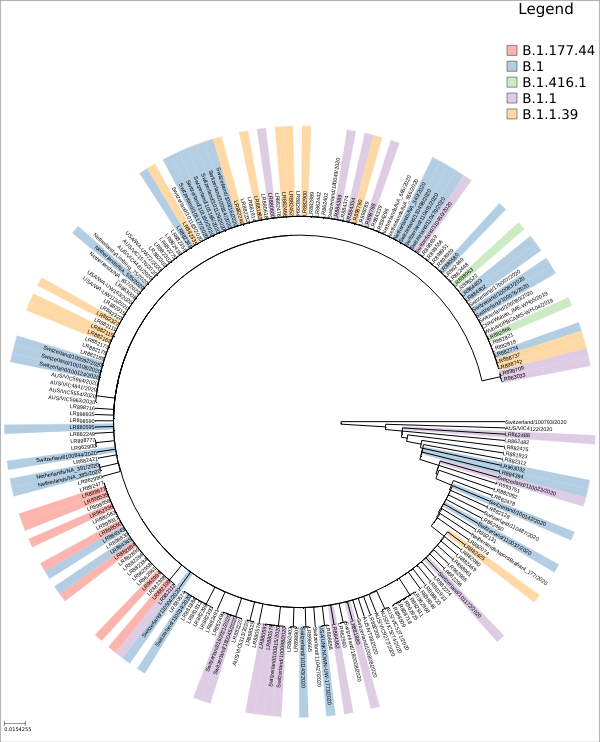

In [73]:
tstk_31 = q31.tree_styler(mode='c', annotate_box_width=24, legend_nsize=24, legend_fsize=24,
                   annotate_opacity_absent=1.0,
                   legend_type_label_present='', legend_type_label_unknown='',
                   legend_title='Legend', annotate_show_box_label=False,
                   include_unknown=False, annotate_color_unknown='black')
for lineage in top_lineages_k31['lineage'].tolist():
    tstk_31 = tstk_31.highlight(q.isa(lineage, isa_column='lineage', kind='dataframe'), legend_label=lineage)
tstk_31.render(w=600)

#### 4.7.2.2. On ML tree

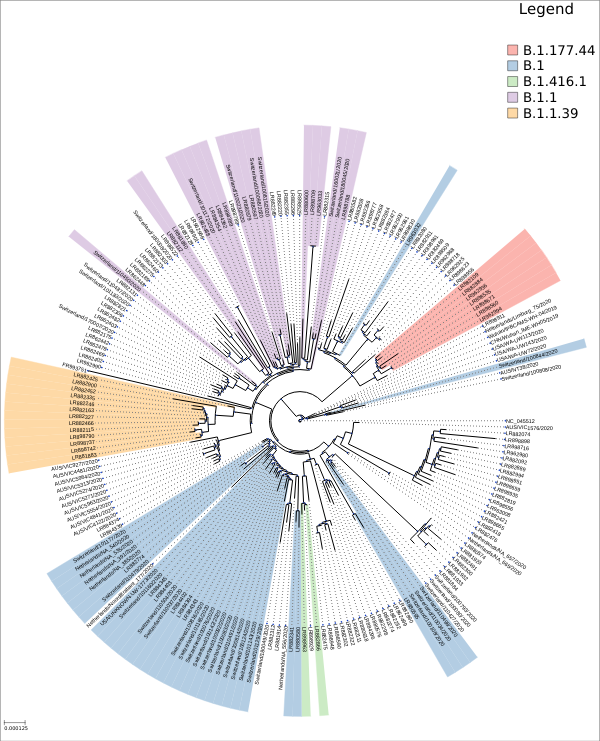

In [74]:
tstk = q.tree_styler(mode='c', annotate_box_width=24, legend_nsize=24, legend_fsize=24,
                   annotate_opacity_absent=1.0,
                   legend_type_label_present='', legend_type_label_unknown='',
                   legend_title='Legend', annotate_show_box_label=False,
                   include_unknown=False, annotate_color_unknown='black',
                   tree_scale=400000,
                  )
for lineage in top_lineages_k31['lineage'].tolist():
    tstk = tstk.highlight(q.isa(lineage, isa_column='lineage', kind='dataframe'), legend_label=lineage)
tstk.render(w=600)